In [137]:
from batcher.base import EEGDataset
from encoder.conformer_braindecode import EEGConformer
from embedder.make import make_embedder
from embedder.base import EmbeddingModel, BaseEmbedder
from decoder.gpt import GPTModel, PretrainedGPT2
from decoder.unembedder import DeconvNet, UnEmbedder

import mne
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader

import argparse
from glob import glob
import gzip
import logging
import os
from pathlib import Path

import mne
import numpy as np
import pandas as pd
from scipy.signal import detrend
import torch
import matplotlib.pyplot as plt
import pathlib
from model import Model 

In [7]:
from preprocess import preprocess_eeg

### Load Data and Create a Batch

In [26]:
data_dir = pathlib.Path("../data/pt/")
files = list(data_dir.glob("*.gz"))
data = EEGDataset(files)

dl = DataLoader(data, batch_size=8, shuffle=True)
batch = next(iter(dl))

Number of subjects loaded:  54


### Init Model Modules

In [27]:
# Init Modules
encoder = EEGConformer(n_chans=20, n_times=500)
embedder = EmbeddingModel(
    in_dim=1080,
    )
decoder = PretrainedGPT2()
unembedder = UnEmbedder(out_dim=1080)

### Init Model From Modules

In [28]:
# yay model works too
model = Model(
    encoder = EEGConformer(n_chans=20, n_times=500),
    embedder = BaseEmbedder(in_dim=1080),
    decoder = PretrainedGPT2(),
    unembedder = UnEmbedder(out_dim=1080)
)

### Pass Data Through Module by Module

In [29]:
# pass thru module by module
model_inputs = batch['inputs']
print(f"Shape of input data: {model_inputs.shape}")
encoded_data = encoder(model_inputs)
print(f"Shape of encoded data: {encoded_data.shape}") 
encoded_data = encoded_data.view(8, 10, -1)
print(f"Reshaped encoded data: {encoded_data.shape}") 
embedded = embedder(encoded_data)
print(f"Shape of emedded data: {embedded.shape}") 
decoded = decoder({'inputs_embeds': embedded, 'attention_mask': batch['attention_mask']})
print(f"Shape of decoded data: {decoded['outputs'].shape}")
unembedded = unembedder(decoded['outputs'])
print(f"Shape of unembedded data: {unembedded['outputs'].shape}")

Shape of input data: torch.Size([8, 10, 20, 500])
Shape of encoded data: torch.Size([80, 27, 40])
Reshaped encoded data: torch.Size([8, 10, 1080])
Shape of emedded data: torch.Size([8, 10, 768])
Shape of decoded data: torch.Size([8, 10, 768])
Shape of unembedded data: torch.Size([8, 10, 1080])


### Pass Data Through Entire Model

In [30]:
fwd = model(batch)
print(f"Shape of model outputs: {fwd['outputs'].shape}")

Shape of model outputs: torch.Size([8, 10, 1080])


## Scratch

In [138]:
edf_file = "/Users/ryanrodriguez/Documents/Work/EEG2/data/edf/000/aaaaaaaa/s001_2015/01_tcp_ar/aaaaaaaa_s001_t000.edf"
raw = mne.io.read_raw_edf(edf_file)

Extracting EDF parameters from /Users/ryanrodriguez/Documents/Work/EEG2/data/edf/000/aaaaaaaa/s001_2015/01_tcp_ar/aaaaaaaa_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [139]:
raw

<RawEDF | aaaaaaaa_s001_t000.edf, 31 x 323840 (1265.0 s), ~35 kB, data not loaded>

In [140]:
processed = preprocess_eeg(edf_file, logger)

Extracting EDF parameters from /Users/ryanrodriguez/Documents/Work/EEG2/data/edf/000/aaaaaaaa/s001_2015/01_tcp_ar/aaaaaaaa_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323839  =      0.000 ...  1264.996 secs...


INFO:__main__:Missing channels ['EEG OZ-REF'] in available channels: 
['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF', 'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF', 'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF', 'EEG T6-REF', 'EEG T1-REF', 'EEG T2-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF', 'EEG EKG1-REF', 'EEG LOC-REF', 'EEG ROC-REF', 'EMG-REF', 'EEG A1-REF', 'EEG A2-REF', 'RESP ABDOMEN-REF', 'IBI', 'BURSTS', 'SUPPR']
INFO:__main__:Available channels: 
['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF', 'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF', 'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF', 'EEG T6-REF', 'EEG T1-REF', 'EEG T2-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF', 'EEG EKG1-REF', 'EEG LOC-REF', 'EEG ROC-REF', 'EMG-REF', 'EEG A1-REF', 'EEG A2-REF', 'RESP ABDOMEN-REF', 'IBI', 'BURSTS', 'SUPPR']
Adding missing channels ['EEG OZ-REF'] 

Creating RawArray with float64 data, n_channels=1, n_times=323840
    Range : 0 ... 323839 =      0.000 ...  1264.996 secs
Ready.


INFO:__main__:Selecting the 22 channels...


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


INFO:__main__:Identifying bad channels...
INFO:__main__:Dropping channels: ['T1', 'T2']
INFO:__main__:Interpolating bad channels...
INFO:__main__:Processing bad channels: ['EEG OZ-REF']


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.7 mm
Computing interpolation matrix from 19 sensor positions
Interpolating 1 sensors


INFO:__main__:Processing all the channels...


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 58.75 Hz)
- Upper passband edge: 61.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 61.25 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


In [10]:
raw

<RawEDF | aaaaaaaa_s001_t000.edf, 31 x 323840 (1265.0 s), ~35 kB, data not loaded>

In [9]:
processed

<RawEDF | aaaaaaaa_s001_t000.edf, 20 x 316250 (1265.0 s), ~48.3 MB, data loaded>

In [52]:
processed_data = processed.get_data()
processed_data.shape
datas  = [processed_data + np.random.rand(processed_data.shape[0],processed_data.shape[1]) for _ in range(20)]

In [162]:
import time
from os.path import getsize


pathlib.Path(np_save_dir).mkdir(parents=True, exist_ok=True)  # Ensure directory exists
start_time = time.time()

results = {}


def profile_file_save_time(file_type: str, datas: list, save_dir:str, file_type_stats:dict, eval_results: dict, gzip=False):
    pathlib.Path(save_dir).mkdir(parents=True, exist_ok=True) 
    start_times = []
    end_times = []
    # Compare npy, npz, hdf5, pt.gz, 
    if file_type == 'npy':
        for i, data in enumerate(datas):
            start_times.append(time.time())
            np.save(pathlib.Path(np_save_dir, f"np_arr_{i}"), data)
            end_times.append(time.time())

        file_type_stats['Save Times'] = [end_times[i] - start_times[i] for i in range(len(datas))]
        file_type_stats['Total Save Time'] = sum(file_type_stats['Save Times'])
        file_type_stats['Avg Save Time'] = np.mean(file_type_stats['Save Times'])
        file_type_stats['Save Time Std'] = np.std(file_type_stats['Save Times'])
    
    elif file_type == 'npz':
        start_time = time.time()
        np.savez_compressed(pathlib.Path(save_dir) / 'compressed', *datas)
        end_time = time.time()
        file_type_stats['Total Save Time'] = end_time - start_time
        file_type_stats['Avg Save Time'] = file_type_stats['Total Save Time']  / len(datas)
        
    elif file_type == 'hdf5':
            ...
    elif file_type == 'pt':
            ...
    else:
        print("Error, unsupported file type")
    
        if gzip: # compress file
            ...
        end_times.append(time.time())


def profile_file_load_time(root: str, file_type: str, file_type_stats:dict, gzip=False):
    start_times = []
    end_times = []
    if file_type == 'npy':
        files = pathlib.Path(root).rglob(f"*.{file_type}")
        for i, file in enumerate(files):
            start_times.append(time.time())
            loaded = np.load(file)
            end_times.append(time.time())
        file_type_stats['Load Times'] = [end_times[i] - start_times[i] for i in range(len(end_times))]
        file_type_stats['Total Load Time'] = sum(file_type_stats['Load Times']) 
        file_type_stats['Avg Load Times'] = np.mean(file_type_stats['Load Times']) 
        file_type_stats['Load Time Std'] = np.std(file_type_stats['Load Times'])
    elif file_type == 'npz':
        file = pathlib.Path(root).glob(f"*.{file_type}")
        overhang_start = time.time()
        compressed_file = np.load(next(file))
        overhang_end = time.time()
        for key in compressed_file.keys():
            start_times.append(time.time())
            arr = compressed_file[key]
            end_times.append(time.time())
        file_type_stats['Array Load Times'] = [end_times[i] - start_times[i] for i in range(len(end_times))]
        file_type_stats['Total Load Time'] = (overhang_end - overhang_start) + sum(file_type_stats['Array Load Times'])
        file_type_stats['Avg Load Time w/ Overhang'] = file_type_stats['Total Load Time'] / len(end_times)
    elif file_type == 'hdf5':
            ...
    elif file_type == 'pt':
            ...
    else:
        print("Error, unsupported file type")
        
    
    
    
def profile_file_size(root: str, file_type: str, file_type_stats:dict):
    files = pathlib.Path(root).rglob(f"*.{file_type}")
    file_sizes = []
    for file in files:
        print(file)
        file_sizes = getsize(file)

    file_type_stats['File Sizes'] = file_sizes
    file_type_stats['Avg File Size'] = np.mean(file_type_stats['File Sizes'])
        

In [165]:
print("Uncompressed .npy")
npy_save_dir = "./npy"
np_stats = {}

profile_file_save_time("npy", datas, npy_save_dir, np_stats, results)
print("Saving")
print(f"Total time to save npy files: {np_stats['Total Save Time']:.5f} seconds")
print(f"Average time to save npy file: {np_stats['Avg Save Time']:.5f} seconds")
print(f"Variance: {np_stats['Save Time Std']:.4f} seconds")
print()

print("Loading")
profile_file_load_time(root = "npy", file_type="npy", file_type_stats=np_stats, gzip=False)
print(f"Average time to load uncompressed file: {np_stats['Avg Load Times']:0.4f}")
print(f"Total time to load uncompressed file: {np_stats['Total Load Time']:0.4f}")
print()


print("File Size")
profile_file_save_time("npy", datas, np_save_dir, np_stats, results)

Uncompressed .npy
Saving
Total time to save npy files: 0.39226 seconds
Average time to save npy file: 0.01961 seconds
Variance: 0.0066 seconds

Loading
Average time to load uncompressed file: 0.0117
Total time to load uncompressed file: 0.2341

File Size


In [ ]:
file_type_stats['Load Times']

In [147]:
print("Compressed .npz")
npz_save_dir = "./npz"
npz_stats = {}

profile_file_save_time("npz", datas, npz_save_dir, npz_stats, results)
print("Saving")
print(f"Total time to save npy files: {np_stats['Total Save Time']:.5f} seconds")
print(f"Average time to save npy file: {np_stats['Avg Save Time']:.5f} seconds")
print()

print("Loading")
profile_file_load_time(root = "npz", file_type="npz", file_type_stats=npz_stats,gzip=False)
print(npz_stats['Avg Load Time w/ Overhang'])
print(npz_stats['Total Load Time'])
print()

print("File Size")
profile_file_save_time("npy", datas, np_save_dir, np_stats, results)


Compressed .npz
Saving
Total time to save npy files: 1.05754 seconds
Average time to save npy file: 0.05288 seconds

Loading

File Size


KeyError: 'Avg Load Times'

In [146]:
profile_file_load_time(root = "npz", file_type="npz", file_type_stats=npz_stats,gzip=False)
print(npz_stats['Avg Load Time w/ Overhang'])
print(npz_stats['Total Load Time'])

0.14000602960586547
2.8001205921173096


In [53]:
def generate_normalized_names(channel_names):
    """
    Generate a dictionary to map original EEG channel names to their normalized
    names based on the standard 10-20 system naming convention, ensuring
    proper case (e.g., 'Fp1' instead of 'FP1').
    Parameters:
    - channel_names: list of str, original channel names from the EEG file.
    Returns:
    - dict: A dictionary where keys are original channel names and values are
            the corresponding normalized names in proper case.
    """
    prefix_removal = "EEG "
    suffix_removals = ["-REF", "-LE"]

    # Mapping of upper case to proper case for the 10-20 system
    proper_case_mapping = {
        'FP1': 'Fp1', 'FP2': 'Fp2',
        'F7': 'F7', 'F3': 'F3', 'FZ': 'Fz', 'F4': 'F4', 'F8': 'F8',
        'T1': 'T1', 'T3': 'T3', 'C3': 'C3', 'CZ': 'Cz', 'C4': 'C4', 'T4': 'T4', 'T2': 'T2',
        'T5': 'T5', 'P3': 'P3', 'PZ': 'Pz', 'P4': 'P4', 'T6': 'T6',
        'O1': 'O1', 'OZ': 'Oz', 'O2': 'O2',
    }

    normalized_names = {}
    for name in channel_names:
        name_short = name
        # Remove the 'EEG ' prefix and any '-REF' or '-LE' suffix
        for suffix in suffix_removals:
            name_short = name_short.replace(suffix, '')
        name_short = name_short.replace(prefix_removal, '')

        # Convert to proper case based on the 10-20 system
        normalized_name = proper_case_mapping.get(name_short.upper())

        # Map the original name to the normalized name
        normalized_names[name] = normalized_name

    return normalized_names


def preprocess_eeg(edf_file, logger, channels = ['FP1', 'FP2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T1', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T2', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'Oz', 'O2']):
    # Load the EDF file
    raw = mne.io.read_raw_edf(edf_file, preload=True)
    # raw = mne.io.read_raw_edf(edf_file, preload=False, verbose='error')

    # Select the 22 channels based on the extended international 10-20 system
    ch_suffixes = [ch.split("-")[-1] for ch in raw.info['ch_names'] if ch.endswith("LE") or ch.endswith("REF")]
    assert len(set(ch_suffixes))==1, f"Multiple channel type detected: {set(ch_suffixes)}"
    channels_formatted = [f'EEG {ch.upper()}-{ch_suffixes[0]}' for ch in channels]
    missing_channels = list(set(channels_formatted)-set(raw.info['ch_names']))
    if len(missing_channels):
        logger.info(f"Missing channels {missing_channels} in available channels: \n{raw.info['ch_names']}")

    if missing_channels:
        logger.info(f"Available channels: \n{raw.info['ch_names']}\nAdding missing channels {missing_channels} with zero values...")
        for ch_name in missing_channels:
            # Create a data array of zeros
            data = np.zeros((1, len(raw.times)))
            # Create an Info object for the new channel
            ch_info = mne.create_info(ch_names=[ch_name], sfreq=raw.info['sfreq'], ch_types='eeg')
            # Create a RawArray and append to the existing Raw object
            missing_raw = mne.io.RawArray(data, ch_info)
            raw.add_channels([missing_raw], force_update_info=True)

        # Mark the newly added channels as bad
        raw.info['bads'].extend(missing_channels)

    # Ensure the specified channels are in the correct order
    raw.reorder_channels(channels_formatted)

    logger.info("Selecting the 22 channels...")
    raw.pick_channels(channels_formatted, ordered=False)

    # Identify bad channels (zero or missing signals)
    logger.info("Identifying bad channels...")
    bad_channels = []
    for ch_name in channels_formatted:
        data, _ = raw[ch_name]
        if np.all(data == 0):
            bad_channels.append(ch_name)

    raw.info['bads'] = bad_channels

    # Rename channels in the raw object
    normalized_names = generate_normalized_names(raw.info['ch_names'])
    raw.rename_channels(normalized_names)
    # Set montage (assuming 10-20 system)
    montage = mne.channels.make_standard_montage('standard_1020')
    # remove channels not present in the 10-20 system
    drop_channels = [ch for ch in raw.info['ch_names'] if ch not in montage.ch_names]
    logger.info(f"Dropping channels: {drop_channels}")

    raw.drop_channels(drop_channels)
    raw.set_montage(montage, match_case=False)
    # Interpolate bad channels (This is a simplified approach)
    logger.info("Interpolating bad channels...")
    if bad_channels:
        logger.info(f"Processing bad channels: {bad_channels}")
        raw.interpolate_bads(reset_bads=True)

    logger.info("Processing all the channels...")
    # Re-reference the EEG signal to the average
    raw.set_eeg_reference(ref_channels='average')

    # Remove power line noise with notch filter and apply bandpass filter
    raw.notch_filter(60, notch_widths=1)
    raw.filter(0.5, 100, fir_design='firwin')

    # Resample to 250 Hz
    raw.resample(250)

    # DC offset correction and remove linear trends
    data = raw.get_data()
    data = detrend(data, type='constant')  # DC offset correction
    data = detrend(data, type='linear')    # Remove linear trends

    # Apply the z-transform along the time dimension
    data = (data - np.mean(data, axis=1, keepdims=True)) / np.std(data, axis=1, keepdims=True)
    raw._data = data

    return raw


In [2]:
import logging

# Set up the logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Example usage
logger.info("This is an info message.")
logger.warning("This is a warning message.")
logger.error("This is an error message.")

INFO:__main__:This is an info message.
ERROR:__main__:This is an error message.


In [57]:
preprocessed = preprocess_eeg(edf_file, logger)
raw = mne.io.read_raw_edf(file)

Extracting EDF parameters from /Users/ryanrodriguez/Documents/Work/EEG2/NeuroGPT/data/aaaaaaaa_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 323839  =      0.000 ...  1264.996 secs...


INFO:__main__:Missing channels ['EEG OZ-REF'] in available channels: 
['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF', 'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF', 'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF', 'EEG T6-REF', 'EEG T1-REF', 'EEG T2-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF', 'EEG EKG1-REF', 'EEG LOC-REF', 'EEG ROC-REF', 'EMG-REF', 'EEG A1-REF', 'EEG A2-REF', 'RESP ABDOMEN-REF', 'IBI', 'BURSTS', 'SUPPR']
INFO:__main__:Available channels: 
['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF', 'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF', 'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF', 'EEG T6-REF', 'EEG T1-REF', 'EEG T2-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF', 'EEG EKG1-REF', 'EEG LOC-REF', 'EEG ROC-REF', 'EMG-REF', 'EEG A1-REF', 'EEG A2-REF', 'RESP ABDOMEN-REF', 'IBI', 'BURSTS', 'SUPPR']
Adding missing channels ['EEG OZ-REF'] 

Creating RawArray with float64 data, n_channels=1, n_times=323840
    Range : 0 ... 323839 =      0.000 ...  1264.996 secs
Ready.


INFO:__main__:Selecting the 22 channels...


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


INFO:__main__:Identifying bad channels...
INFO:__main__:Dropping channels: ['T1', 'T2']
INFO:__main__:Interpolating bad channels...
INFO:__main__:Processing bad channels: ['EEG OZ-REF']


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.7 mm
Computing interpolation matrix from 19 sensor positions
Interpolating 1 sensors


INFO:__main__:Processing all the channels...


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.00
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 58.75 Hz)
- Upper passband edge: 61.00 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 61.25 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Extracting EDF parameters from /Users/ryanrodriguez/Documents/Work/EEG2/NeuroGPT/data/aaaaaaaa_s001_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [58]:
raw

<RawEDF | aaaaaaaa_s001_t000.edf, 31 x 323840 (1265.0 s), ~35 kB, data not loaded>

In [59]:
preprocessed

<RawEDF | aaaaaaaa_s001_t000.edf, 20 x 316250 (1265.0 s), ~48.3 MB, data loaded>

/var/folders/3_/f8wt55b12b5683gxyp7dcqyc0000gn/T/ipykernel_71896/23803049.py:17: RuntimeWarning: Loading an EDF with mixed sampling frequencies and preload=False will result in edge artifacts. It is recommended to use preload=True.See also https://github.com/mne-tools/mne-python/issues/10635
  file.plot(duration=duration, start=start, scalings='auto', title='Raw EEG Data')
/var/folders/3_/f8wt55b12b5683gxyp7dcqyc0000gn/T/ipykernel_71896/23803049.py:17: RuntimeWarning: Loading an EDF with mixed sampling frequencies and preload=False will result in edge artifacts. It is recommended to use preload=True.See also https://github.com/mne-tools/mne-python/issues/10635
  file.plot(duration=duration, start=start, scalings='auto', title='Raw EEG Data')


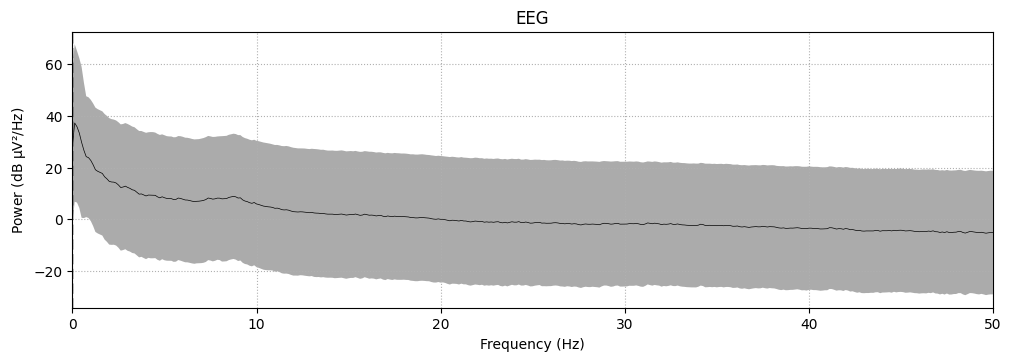

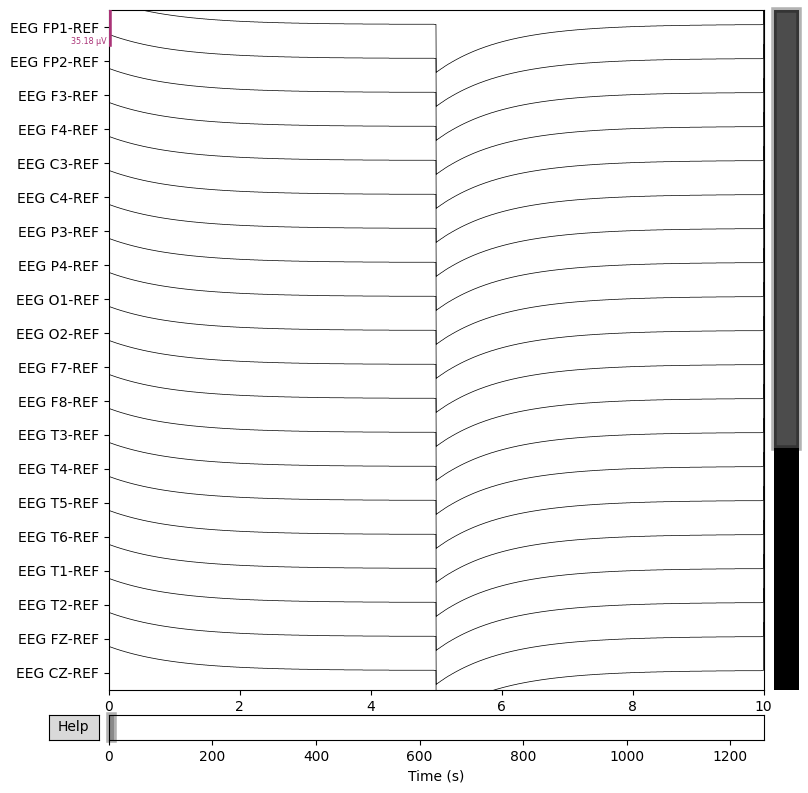

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.000 (s)
Plotting power spectral density (dB=True).


/Users/ryanrodriguez/PycharmProjects/personal/EEG2/lib/python3.9/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


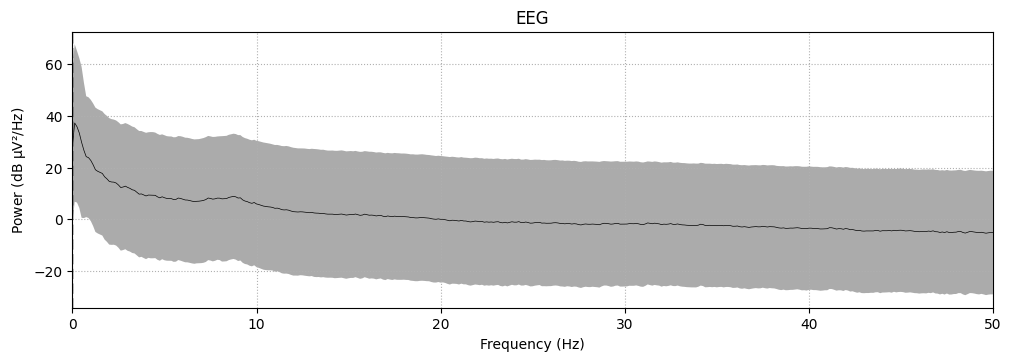

In [68]:
def visualize_eeg(loaded_eeg_file=None, edf_file_nm=None, duration=10, start=0, show_psd=True, show_topomap=True):
    """
    Visualize EEG data from an EDF file using MNE.

    Parameters:
    - edf_file (str): Path to the EDF file.
    - duration (int): Duration of the time window to show in seconds.
    - start (int): Starting point of the time window in seconds.
    - show_psd (bool): Whether to show the Power Spectral Density (PSD) plot.
    - show_topomap (bool): Whether to show the topographic distribution.
    """
    # Load the EDF file
    if loaded_eeg_file:
        file = loaded_eeg_file
    else:
        file = mne.io.read_raw_edf(edf_file_nm, preload=True)
    file.plot(duration=duration, start=start, scalings='auto', title='Raw EEG Data')

    # Plot the Power Spectral Density (PSD) if specified
    if show_psd:
        file.plot_psd(fmax=50, average=True)
    
    # Plot the topographic distribution if specified
    # if show_topomap:
    #     # Select a time window for the topomap
    #     times = [start + duration / 2]  # Middle of the window
    #     file.plot_sensors(show_names=True)
    #     file.plot_topomap(times=times, ch_type='eeg', title='EEG Topomap')

    plt.show()

# Example usage
visualize_eeg(loaded_eeg_file=raw, duration=10, start=0)

In [69]:
file

'../../data/aaaaaaaa_s001_t000.edf'

In [16]:
import embedder.base

ModuleNotFoundError: No module named 'embedder'

In [161]:
sum(np_stats['Load Times'])
np.mean(np_stats['Load Times'])

0.024524319171905517